<div style="background-color:orange; color:white; text-align:center; padding:10px; border-radius:5px;">
<h2 style="margin: auto; padding: 20px; color:#fff; ">Produisez une étude de marché avec Python - Partie n°2 : clustering </h2>
</div>

# OBJECTIF DE CE NOTEBOOK

Ce notebook est le second des deux notebooks qui composent notre étude de marché. Il contient l'analyse des groupements de pays en utilisant la classification ascendante hiérarchique puis la méthode des *k-means*. Il contient également une ACP afin de visualier les résultats de l'analyse.

# MISSION

Nous sommes en poste chez La poule qui chante, une entreprise française d’agroalimentaire qui souhaite se développer à l'international.

Cependant, la liste des pays potentiels dans lesquels s'implanter est longue. Pour cela, nous allons réaliser une analyse des groupements de pays que l'on pourra cibler grâce à différentes méthodes de clustering, puis nous approfondirons l'étude de marché.

Le jeu de données qui va être utilisé a été préparé à partir des "statistiques de la Food and Agriculture Organization of the United Nations (FAO)".
Il contient différents indicateurs sélectionnés ou calculés en nous inspirant de l'analyse PESTEL dont voici la liste.

|Nom de variable               |Indicateur<sup>[1]</sup>                             |Information                                      |
|------------------------------|-----------------------------------------------------|-------------------------------------------------|
|`population_milliers_hab`     |Population en milliers d'habitants                   |Potentiel du marché                              |
|`evolution_population_pct`    |Evolution démographique moyenne entre 2000 et 2017   |Dynamique de la taille marché                    |
|`consommation_volaille_pct`   |Ratio de consommation de volaille dans l'alimentation|Appétence des consommateurs pour la volaille     |
|`tdi_pct`                     |Taux de dépendance aux importations pour la volaille |Nécessité des pays à importer                    |
|`disponibilite_kg_p_an`       |Disponibilité de volaille par personne               |Volume de volaille alimentaire                   |
|`taux_croissance_pct`         |Taux de croissance du PIB en 2017                    |Dynamique économique du pays                     |
|`revenu_par_habitant_usd`     |Revenu par habitant en US$                           |Pouvoir d'achat des consommateurs                |
|`indice_stabilite_politique`  |Indice de stabilité politique                        |Facilité et risques liés aux échanges commerciaux|

Les indicateurs sont donnés pour l'année 2017.

<div style="background-color:orange; color:white; text-align:center; padding:10px; border-radius:5px;">
<h2 style="margin: auto; padding: 20px; color:#fff; ">Etape 1 - Importation, Chargement et Préparation des données</h2>
</div>

<div style="background-color: RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color:#fff; ">1.2 - Importation des librairies</h3>
</div>

In [301]:
import numpy as np
import math
import pandas as pd
import os
os.environ["OMP_NUM_THREADS"] = "1"

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import seaborn as sns

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score

<div style="background-color: RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color:#fff; ">1.4 - Chargement des datasets</h3>
</div>

On importe dans un *DataFrame* les indicateurs des différents pays à partir du jeu de données préparé précédemment.

In [305]:
df_indicateurs = pd.read_csv('indicateurs-pays-2017.csv')
df_indicateurs.head(3)

,pays,population_milliers_hab,evolution_population_pct,consommation_volaille_pct,tdi_pct,disponibilite_kg_p_an,taux_croissance_pct,revenu_par_habitant_usd,indice_stabilite_politique
0,Afghanistan,36296.113,3.29,0.42,50.88,1.53,4.865790,537.126294,-2.80
1,Afrique du Sud,57009.756,1.40,6.41,24.27,35.69,17.703800,6537.504869,-0.28
2,Albanie,2884.169,-0.45,1.29,74.51,16.36,9.765944,4532.791976,0.38


Les algorithmes de *clustering* que nous allons utiliser dans la suite de cette étude nécessitent que nous ne leur fournissions que les valeurs numériques des indicateurs.

In [308]:
X = df_indicateurs.drop('pays', axis='columns')

Nous allons également normaliser les données, c'est à dire les réduire puis les centrer. La réduction va gommer les différences d'échelles entre variables et la centralisation va recentrer les variables autour de 0 ce qui facilitera la visualisation et l'interprétation des résultats.

In [311]:
# Standardise les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(X_scaled[:2])

[[-0.04443898  1.56843662 -1.02862853  0.19784825 -1.19062167 -0.4422584
  -0.72800389 -3.05950463]
 [ 0.09051559  0.02232787  1.3752188  -0.36670685  0.9675434   1.50832969
  -0.39684311 -0.23729244]]


La dernière étape consiste à créer deux listes : une contenant les pays, une autre contenant les indicateurs.

In [314]:
pays = df_indicateurs['pays'].to_numpy()

indicateurs = df_indicateurs.drop(columns='pays').columns.to_numpy()

<div style="background-color: RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color:#fff; ">1.6 - Clusterings</h3>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">Classification Ascendante Hiérarchique (CAH)</h3>
</div>

La première méthode que nous allons utiliser est la **classification ascendante hiérarchique** qui consiste à regrouper, de manière itérative, les individus (ici les pays), à partir de la « distance » qui les sépare. Les distances entre individus sont regroupées dans une matrice calculée à partir des données initiales.

Nous allons calculer la **matrice des distances**, aussi appelée matrice de liaison, puis tracer le résultat des différentes itérations sous forme d'un dendrogramme.

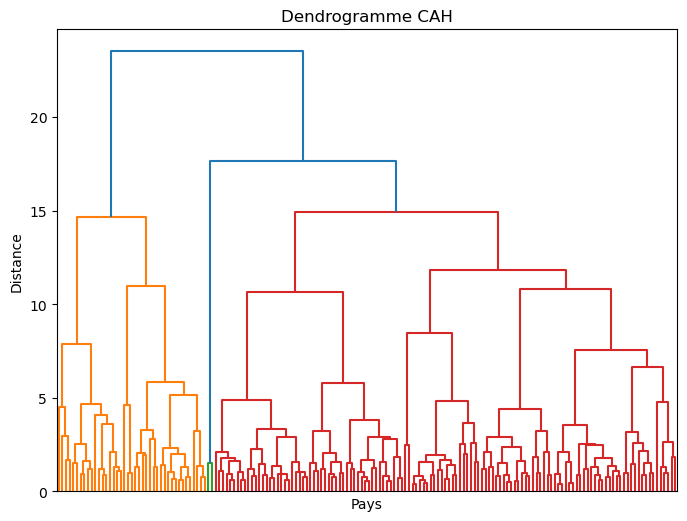

In [319]:
# Calcule la matrice de liaison
Z = linkage(X_scaled, method='ward', metric='euclidean')

# Trace le dendogramme
fig, ax = plt.subplots(figsize=(8, 6))

dn = dendrogram(Z, no_labels=True, orientation='top', ax=ax)

ax.set_title('Dendrogramme CAH')
ax.set_xlabel('Pays')
ax.set_ylabel('Distance')

plt.show()

del  fig, ax, dn

On cherche ensuite la distance (en ordonnée) à laquelle couper le dendrogramme de manière à former les *clusters*. Cependant, le choix de la distance par lecture visuelle est subjective, d'autant plus avec le nombre d'individus présents dans nos données.

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">Coefficient de Silhouette</h3>
</div>

Pour choisir un nombre de *clusters* de manière plus objective, nous allons nous appuyer sur le **coefficient de Silhouette** qui rend compte de la qualité d'un regroupement. Il mesure à quel point les individus d'un même groupe sont similaires entre eux par rapport aux objets des autres groupes.

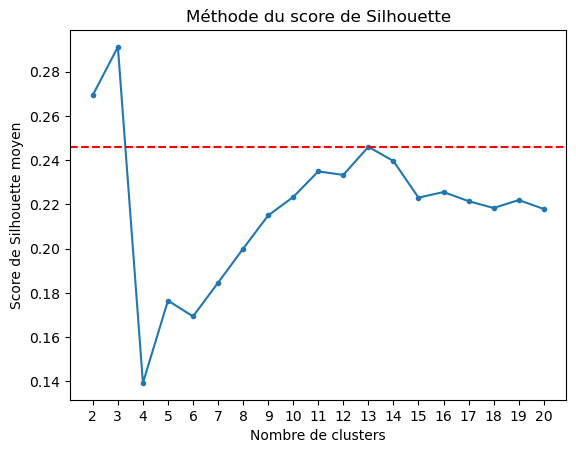

In [323]:
# Initialise les variables
n_clusters_range = range(2, 21)
silhouette_avg_scores = []

# Calcule le score de Silhouette moyen pour chaque valeur du nombre de clusters
for n_clusters in n_clusters_range:
    clustering = fcluster(Z, t=n_clusters, criterion='maxclust')
    silhouette_avg = silhouette_score(X_scaled, clustering)
    silhouette_avg_scores.append(silhouette_avg)

# Trace le graphique
fig, ax = plt.subplots()

plt.plot(n_clusters_range, silhouette_avg_scores, marker='.')
plt.axhline(y=silhouette_avg_scores[11], linestyle = '--', color='r')

# Définit la position des graduations
ax.xaxis.set_major_locator(ticker.IndexLocator(1, 0))

ax.set_xlabel('Nombre de clusters')
ax.set_ylabel('Score de Silhouette moyen')
ax.set_title('Méthode du score de Silhouette')

plt.show()

del (n_clusters_range, silhouette_avg_scores, n_clusters, clustering,
     silhouette_avg, fig, ax)

La méthode du score de Silhouette nous indique le nombre optimal de *clusters* est 3. Néanmoins, cela est trop peu par rapport au nombre de pays à grouper. On choisit donc la deuxième meilleure valeur qui est de **13**.

In [326]:
# Initialise le nombre de clusters
n_clusters = 13

# Effectue le clustering
clustering = fcluster(Z, t=n_clusters, criterion='maxclust')

Le résultat du *clustering* est un *array* qui va nous servir à associer les groupes calculés avec le *DataFrame* contenant les indicateurs par pays.

In [329]:
df_indicateurs['cluster_cah'] = clustering

Cela nous permet notamment d'affiche les pays qui composent chaque groupe.

In [332]:
# Crée la liste des clusters triés par ordre croissant
clusters = np.sort(df_indicateurs['cluster_cah'].unique())

# Liste les pays de chaque cluster et les affiche
for cluster in clusters:
    n_pays = len(
        df_indicateurs.loc[df_indicateurs['cluster_cah'] == cluster, 'pays'])
    liste_pays = list(
        df_indicateurs.loc[df_indicateurs['cluster_cah'] == cluster, 'pays'])

    print(f'Cluster {cluster} - {n_pays} pays')
    print(f'{liste_pays}')

del clusters, cluster, n_pays, liste_pays

Cluster 1 - 4 pays
['Arabie saoudite', 'Émirats arabes unis', 'Israël', 'Koweït']
Cluster 2 - 14 pays
['Antigua-et-Barbuda', 'Bahamas', 'Barbade', 'Dominique', 'Grenade', 'Jamaïque', 'Maurice', 'Nouvelle-Calédonie', 'Polynésie française', 'Sainte-Lucie', 'Saint-Kitts-et-Nevis', 'Saint-Vincent-et-les Grenadines', 'Samoa', 'Trinité-et-Tobago']
Cluster 3 - 3 pays
['Belgique', 'Chine - RAS de Hong-Kong', 'Pays-Bas']
Cluster 4 - 20 pays
['Allemagne', 'Australie', 'Autriche', 'Canada', 'Chine - RAS de Macao', 'Danemark', "États-Unis d'Amérique", 'Finlande', 'France', 'Irlande', 'Islande', 'Italie', 'Japon', 'Luxembourg', 'Norvège', 'Nouvelle-Zélande', 'République de Corée', "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord", 'Suède', 'Suisse']
Cluster 5 - 2 pays
['Chine, continentale', 'Inde']
Cluster 6 - 26 pays
['Albanie', 'Arménie', 'Bosnie-Herzégovine', 'Bulgarie', 'Chypre', 'Croatie', 'Cuba', 'Espagne', 'Estonie', 'Fidji', 'Géorgie', 'Grèce', 'Hongrie', 'Lesotho', 'Lettonie', 'Lituan

On peut également synthétiser les indicateurs des *clusters* en calculant leur moyenne.

In [335]:
cah_clusters_statistics = (
    df_indicateurs.groupby('cluster_cah')[indicateurs].mean()
)

(cah_clusters_statistics
 .T.style.background_gradient(axis='columns').format('{:.2f}')
)

cluster_cah,1,2,3,4,5,6,7,8,9,10,11,12,13
population_milliers_hab,13722.08,543.33,11915.81,44731.37,1379849.29,7494.07,39256.92,62922.54,48631.70,4392.69,44430.93,12876.78,43999.18
evolution_population_pct,3.82,0.71,0.54,0.85,0.97,-0.08,1.43,1.50,2.86,2.50,1.39,2.20,-0.15
consommation_volaille_pct,7.31,8.56,3.43,2.98,0.84,2.37,4.53,2.76,0.84,2.05,1.02,1.25,2.32
tdi_pct,59.69,71.78,260.40,35.67,1.25,47.74,8.75,6.48,16.76,85.10,9.47,62.42,13.27
disponibilite_kg_p_an,50.12,50.30,28.83,26.57,7.28,20.25,29.11,16.62,3.79,11.87,6.04,7.47,19.78
taux_croissance_pct,9.11,3.60,6.16,6.64,12.08,9.03,6.24,-20.93,6.31,5.54,9.26,18.94,21.23
revenu_par_habitant_usd,34907.87,14719.40,46731.76,53939.68,5317.33,13089.46,7352.74,4792.22,1561.44,3414.44,3210.91,2594.57,5839.48
indice_stabilite_politique,-0.24,0.77,0.73,0.92,-0.49,0.43,-0.35,-1.34,-1.55,0.09,-0.30,-0.23,-0.80


On visualise assez bien ce qui caractérise chacun des groupes. Les *clusters* 1 à 4 ont une majorité d'indicateurs ayant des valeurs assez élevées. Nous n'allons retenir que ces derniers pour afficher un peu plus de détail grâce à une fonction qui nous permettra de reproduire le graphique avec les résultats des autres classifications.

In [338]:
def clusters_boxplot(clusters, clusters_retenus):
    '''
    Trace la dispersion des indicateurs pour chaque cluster.
    Paramètres :
    - clusters : la série contenant les clusters.
    - clusters_retenus : la liste des clusters à analyser.
    '''
    # Crée un DataFrame temporaire avec les clusters retenus
    df_temp = df_indicateurs.loc[clusters.isin(clusters_retenus)].copy()
    df_temp['cluster'] = clusters[clusters.isin(clusters_retenus)]

    # Liste des indicateurs numériques si non déjà définie
    global indicateurs
    try:
        indicateurs
    except NameError:
        indicateurs = df_indicateurs.select_dtypes(include='number').columns.tolist()

    # Détermine dynamiquement la grille
    n = len(indicateurs)
    n_cols = 3
    n_rows = math.ceil(n / n_cols)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3.2, n_rows * 2.56))
    axs = axs.flatten()  # pour un accès simple avec axs[i]

    # Trace les boxplots
    for i, indicateur in enumerate(indicateurs):
        sns.boxplot(
            data=df_temp,
            x=indicateur,
            y='cluster',
            orient='h',
            ax=axs[i]
        )
        axs[i].set_title(indicateur, fontsize=10)
        axs[i].tick_params(axis='x', labelsize=8.5)

    # Supprime les axes inutilisés
    for j in range(len(indicateurs), len(axs)):
        fig.delaxes(axs[j])

    fig.suptitle('Dispersion des indicateurs par cluster', fontsize=14)
    plt.tight_layout()
    plt.show()

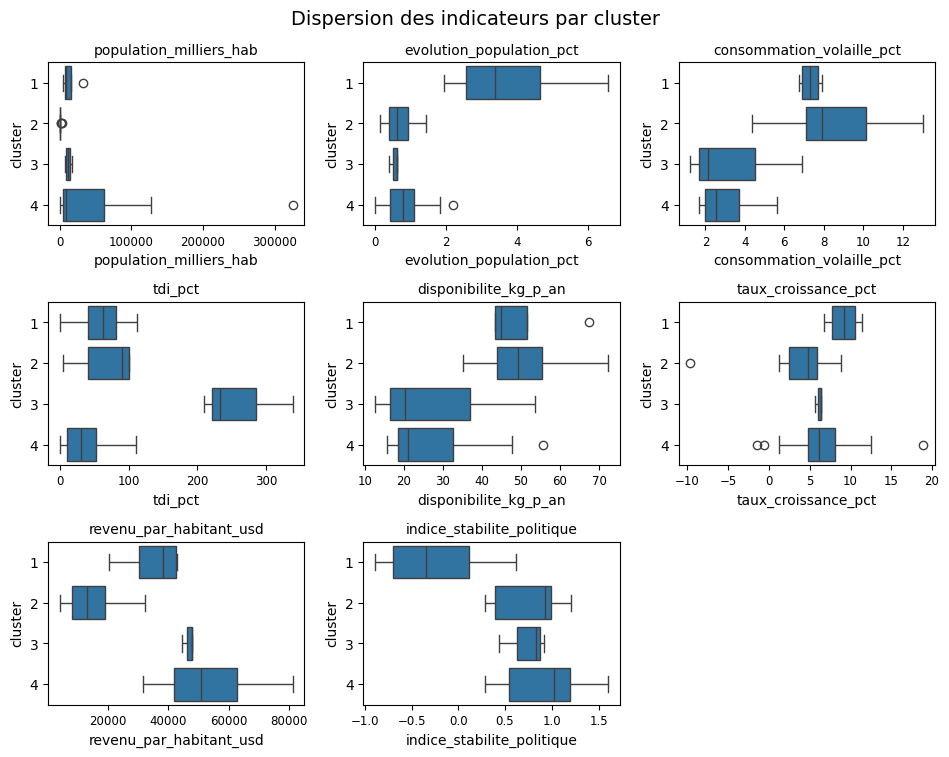

In [340]:
clusters_boxplot(df_indicateurs['cluster_cah'], [1, 2, 3, 4])

Les groupes 1 et 2 ont une forte consommation de poulet et une disponibilité importante. Cependant le groupe 1 a un indice de stabilité, la plupart du temps, négatif et le groupe 2 a des revenus assez faibles comparé aux groupes 3 et 4. De plus le second groupe est uniquement composé d'îles ce qui ne facilite pas la logistique.

Le groupe 3 a une dépendance importante aux importations avec des revenus assez haut. Le groupe 4 a la population la plus forte avec les meilleurs revenus.

En conclusion de cette première méthode de *clustering*, on retient les pays des groupes 3 et 4. On sauvegarder la liste pour la comparer avec le résultat des autres méthodes de classification.

In [342]:
clusters_retenus_cah = [3, 4]

pays_retenus_cah = set(
    df_indicateurs.loc[df_indicateurs['cluster_cah'].isin([3, 4]), 'pays']
)

In [343]:
del n_clusters, clustering, cah_clusters_statistics, Z

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">1.6 - Classification k-means</h3>
</div>

La seconde méthode que nous allons utiliser est la **classification k-means**. Elle va regrouper les individus en cherchant à minimiser l'inertie intraclasse de chaque groupe. Pour cela, l'algorithme utilise les centres de gravité (centroïdes) des groupes. Au départ, les centroïdes sont placés aléatoirement puis, ils sont recaculés à chaque itération jusqu'à ce que les résultats de l'algorithme convergent.

Pour choisir le nombre optimal de *clusters* nous allons nous appuyer sur la **méthode du coude** dans laquelle nous allons calculer l'inertie intraclasse en fonction du nombre de groupes. On cherchera alors à déterminer à partir de quand l'augmentation du nombre de *clusters* n'a plus un impact significatif sur la diminution de l'inertie.

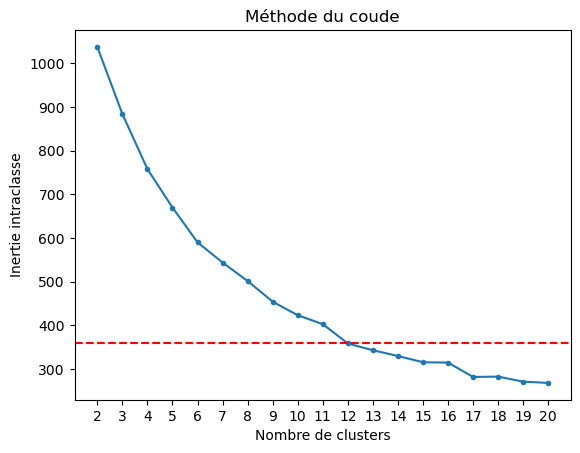

In [349]:
import warnings
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak.*")
# Initialise les variables
n_clusters_range = range(2, 21)
inertias = []

# Calcul l'inertie pour chaque valeur du nombre de clusters
for n_clusters in n_clusters_range:
    clustering = KMeans(n_clusters=n_clusters, n_init='auto', init='random',
                        random_state=0)
    clustering = clustering.fit(X_scaled)
    inertias.append(clustering.inertia_)

# Trace le graphique
fig, ax = plt.subplots()

plt.plot(n_clusters_range, inertias, marker='.')
plt.axhline(y=inertias[10], linestyle='--', color='r')

# Définit la position des graduations
ax.xaxis.set_major_locator(ticker.IndexLocator(1, 0))

ax.set_xlabel('Nombre de clusters')
ax.set_ylabel('Inertie intraclasse')
ax.set_title('Méthode du coude')

plt.show()

Le graphique montre une cassure à 12 *clusters*. Pour confirmer ce résultat, calculons une nouvelle fois les scores de Silhouette.

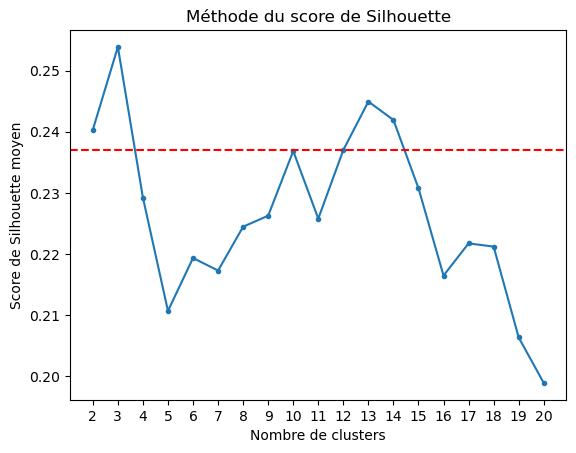

In [352]:
# Initialise les variables
n_clusters_range = range(2, 21)
silhouette_avg_scores = []

# Calcule le score de Silhouette moyen pour chaque nombre de clusters
for n_clusters in n_clusters_range:
    clustering = KMeans(n_clusters=n_clusters, n_init='auto', init='random',
                      random_state=0)
    clustering = clustering.fit(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, clustering.labels_)
    silhouette_avg_scores.append(silhouette_avg)

# Trace le graphique
fig, ax = plt.subplots()

plt.plot(n_clusters_range, silhouette_avg_scores, marker='.')
plt.axhline(y=silhouette_avg_scores[10], linestyle = '--', color='r')

# Définit la position des graduations
ax.xaxis.set_major_locator(ticker.IndexLocator(1, 0))

ax.set_xlabel('Nombre de clusters')
ax.set_ylabel('Score de Silhouette moyen')
ax.set_title('Méthode du score de Silhouette')

plt.show()

del (n_clusters_range, silhouette_avg_scores, n_clusters, clustering,
     silhouette_avg, fig, ax)

Le résultat est identique. On choisit donc de travailler avec **12** *clusters*.

In [355]:
# Initialise le nombre de clusters
n_clusters = 12

# Effectue le clustering
clustering = KMeans(n_clusters=n_clusters, n_init='auto', init='random',
                    random_state=0)
clustering.fit(X_scaled)

KMeans(init='random', n_clusters=12, random_state=0)

On associe nos groupes au *DataFrame* initial.

In [358]:
df_indicateurs['cluster_kmeans'] = clustering.labels_ + 1

Puis on affiche les pays qui composent chaque groupe.

In [361]:
# Crée la liste des clusters triés par ordre croissant
clusters = np.sort(df_indicateurs['cluster_kmeans'].unique())

# Liste les pays de chaque cluster et les affiche
for cluster in clusters:
    n_pays = len(
        df_indicateurs.loc[df_indicateurs['cluster_kmeans'] == cluster, 'pays'])
    liste_pays = list(
        df_indicateurs.loc[df_indicateurs['cluster_kmeans'] == cluster, 'pays'])

    print(f'Cluster {cluster} - {n_pays} pays')
    print(f'{liste_pays}')

del clusters, cluster, n_pays, liste_pays

Cluster 1 - 3 pays
['Belgique', 'Chine - RAS de Hong-Kong', 'Pays-Bas']
Cluster 2 - 20 pays
['Azerbaïdjan', 'El Salvador', 'Équateur', 'Guatemala', 'Honduras', 'Indonésie', "Iran (République islamique d')", 'Maroc', 'Myanmar', 'Nicaragua', 'Paraguay', 'Pérou', 'Philippines', 'République populaire démocratique de Corée', 'Sri Lanka', 'Thaïlande', 'Tunisie', 'Turquie', 'Viet Nam', 'Zimbabwe']
Cluster 3 - 2 pays
['Chine, continentale', 'Inde']
Cluster 4 - 30 pays
['Albanie', 'Arménie', 'Bélarus', 'Bosnie-Herzégovine', 'Bulgarie', 'Chypre', 'Croatie', 'Cuba', 'Espagne', 'Estonie', 'Fidji', 'Géorgie', 'Grèce', 'Hongrie', 'Italie', 'Lesotho', 'Lettonie', 'Lituanie', 'Macédoine du Nord', 'Malte', 'Monténégro', 'Pologne', 'Portugal', 'République de Corée', 'Roumanie', 'Serbie', 'Slovaquie', 'Slovénie', 'Tchéquie', 'Uruguay']
Cluster 5 - 18 pays
['Allemagne', 'Australie', 'Autriche', 'Canada', 'Chine - RAS de Macao', 'Danemark', "États-Unis d'Amérique", 'Finlande', 'France', 'Irlande', 'Islande

Enfin, on affiche les centroïdes des indicateurs, qui correspondent à leurs moyennes, grâce à l'attribut `cluster_centers_`. Pour récupérer les valeurs réelles non normalisées, on utilise la méthode `inverse_transform()` de `StandardScaler()`.

In [364]:
# Crée un DataFrame à partir des centroïdes avec les données non normalisées
kmeans_clusters_statistics = pd.DataFrame(
    scaler.inverse_transform(clustering.cluster_centers_)).T

# Définit les indicateurs comme index
kmeans_clusters_statistics = kmeans_clusters_statistics.set_index(indicateurs)

# Renomme les colonnes
kmeans_clusters_statistics.columns = kmeans_clusters_statistics.columns + 1

# Affiche le DataFrame
(kmeans_clusters_statistics
 .style.background_gradient(axis='columns').format('{:.2f}'))

,1,2,3,4,5,6,7,8,9,10,11,12
population_milliers_hab,11915.81,48033.77,1379849.29,11190.67,43492.07,5068.51,32175.89,62922.54,5370.65,285.10,30044.92,49085.33
evolution_population_pct,0.54,1.21,0.97,-0.07,0.90,4.49,1.43,1.50,2.25,0.75,1.33,2.72
consommation_volaille_pct,3.43,2.59,0.84,2.35,3.08,5.26,5.73,2.76,1.42,8.78,1.58,0.79
tdi_pct,260.40,6.67,1.25,43.35,38.41,96.77,15.48,6.48,75.74,81.77,33.57,13.30
disponibilite_kg_p_an,28.83,15.66,7.28,20.32,27.55,35.17,37.69,16.62,7.81,51.26,11.07,3.71
taux_croissance_pct,6.16,5.53,12.08,9.19,6.67,8.10,8.15,-20.93,6.93,3.02,21.68,6.82
revenu_par_habitant_usd,46731.76,4020.12,5317.33,14028.95,56347.97,25083.20,11467.30,4792.22,2435.80,15856.02,3639.45,1590.12
indice_stabilite_politique,0.73,-0.56,-0.49,0.39,0.99,0.30,-0.07,-1.34,0.02,0.79,-0.52,-1.33


Cette fois, nous allons retenir les *clusters* 4, 5, 8 et 10 qui présentent une majorité d'indicateurs favorables. Nous allons les visualiser plus en détail dans des *boxplots*.

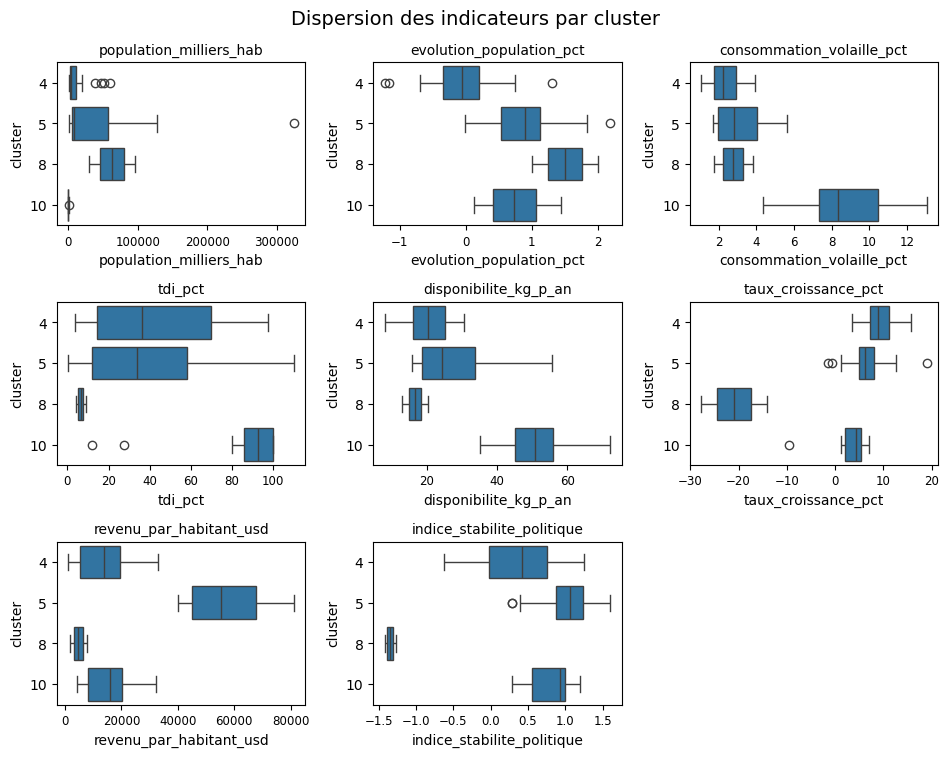

In [367]:
clusters_boxplot(df_indicateurs['cluster_kmeans'], [4, 5, 8, 10])

Les groupes 4 et 8 ont une plus forte consommation de poulet et une plus grande disponibilité. Cependant le groupe 4 a un indice de stabilité souvent négatif et les pays ont des revenus plus faibles que ceux des groupes 5 et 10. De plus, le groupe 8 est uniquement composé d'îles ce qui ne facilite pas la logistique.

Le groupe 10 a une dépendance importante aux importations avec des revenus assez haut. Le groupe 5 a la population la plus forte avec les meilleurs revenus.

En conclusion de cette deuxième méthode de *clustering*, on retient les pays des groupes 5 et 10 que nous allons sauvegarder dans une liste pour la comparer avec le résultat des autres méthodes de classification.

In [369]:
clusters_retenus_kmeans = [5, 10]

pays_retenus_kmeans = set(
    df_indicateurs.loc[df_indicateurs['cluster_kmeans'].isin([5, 10]), 'pays']
)

In [372]:
del n_clusters, clustering, kmeans_clusters_statistics

<div style="background-color: RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color:#fff; ">Classification DBSCAN</h3>
</div>

La troisième et dernière méthode de classification des données que nous allons utiliser sera **DBSCAN**. L'algorithme fonctionne par densité en itérant sur chacun des points et en cherchant à déterminer ses « voisins ». Les points et leurs voisins seront considérés comme faisant partie d'un même *cluster*, ceux n'étant rattachés à aucun groupe seront considérés comme du « bruit ».

Nous avons deux paramètres à définir pour utiliser DBSCAN :
* `min_samples` : qui est le nombre minimum de points à considérer pour définir un *cluster* ;
* `eps` : qui est le rayon dans lequel doivent se trouver les points pour être définis comme voisins.

Dans notre cas, on choisit la valeur de **2** pour `min_samples` en nous basant sur les résultats des autres classifications qui ont toutes les deux formé des *clusters* de 2 pays.

Pour la valeur d'`eps`, il n'est pas possible de choisir une valeur au hasard, nous allons donc de nouveau nous aider du coefficient de Silhouette en visualisant également le nombre de groupes formés.

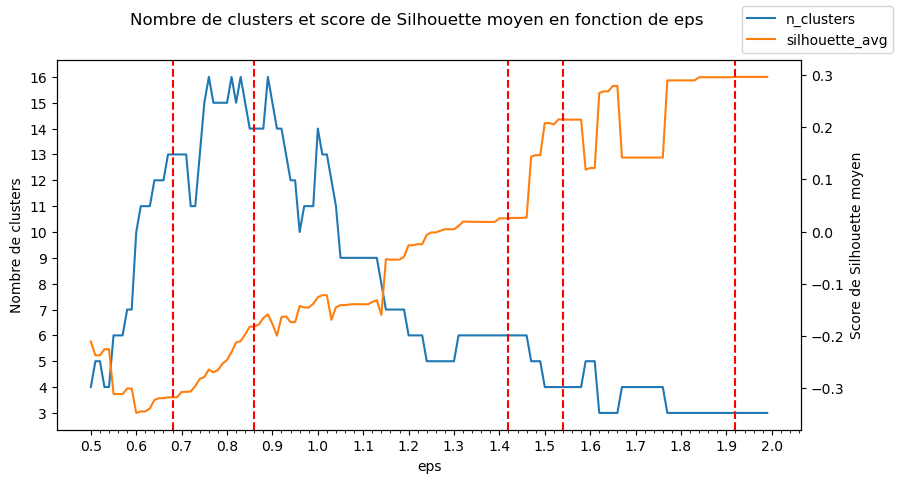

In [376]:
# Initialise les variables
eps_range = np.arange(0.5, 2, 0.01)
n_clusters = []
silhouette_avg_scores = []

# Calcule le nombre de clusters et le score de Silhouette moyen pour chaque
# valeur de 'eps'
for eps in eps_range:

    clustering = DBSCAN(eps=eps, min_samples=2)
    clustering = clustering.fit(X_scaled)

    # Compte le nombre de clusters en décomptant le bruit (cluster '-1')
    if -1 in clustering.labels_:
        n_clusters_ = len(np.unique(clustering.labels_)) - 1
    else:
        n_clusters_ = len(np.unique(clustering.labels_))
    n_clusters.append(n_clusters_)

    # Moyenne les scores de Silhouette s'il y a au moins 2 clusters
    if n_clusters_ < 2:
        silhouette_avg_scores.append(0)
    else:
        silhouette_avg = silhouette_score(X_scaled, clustering.labels_)
        silhouette_avg_scores.append(silhouette_avg)

# Trace les graphiques
fig, ax1 = plt.subplots(figsize=(9.6, 4.8))
ax2 = ax1.twinx()

ax1.plot(eps_range, n_clusters, label='n_clusters')
ax2.plot(eps_range, silhouette_avg_scores, color='C1', label='silhouette_avg')
plt.axvline(x=0.68, linestyle = '--', color='r')
plt.axvline(x=0.86, linestyle = '--', color='r')
plt.axvline(x=1.42, linestyle = '--', color='r')
plt.axvline(x=1.54, linestyle = '--', color='r')
plt.axvline(x=1.92, linestyle = '--', color='r')

# Définie la position des graduations
ax1.xaxis.set_major_locator(ticker.IndexLocator(0.1, 0))
ax1.xaxis.set_minor_locator(ticker.IndexLocator(0.02, 0))
ax1.yaxis.set_major_locator(ticker.IndexLocator(1, 0))

ax1.set_xlabel('eps')
ax1.set_ylabel('Nombre de clusters')
ax2.set_ylabel('Score de Silhouette moyen')

fig.suptitle(
    f'Nombre de clusters et score de Silhouette moyen en fonction de eps'
)

fig.legend()

plt.show()

del (eps_range, n_clusters, silhouette_avg_scores, eps, clustering,
     n_clusters_, silhouette_avg, fig, ax1, ax2)

A la lecture du graphique, il paraît compliqué de choisir une valeur d'`eps` qui nous permette d'exploiter le résultat du *clustering*. En effet, nous avons le choix entre :
* un nombre de groupes semblable aux autres méthodes de classification (> 10) mais avec un score de Silouette moyen < 0 ;
* un score de Silhouette moyen correct mais un nombre de groupes assez faible par rapport aux nombre de pays.

Ce qu'il nous manque c'est la taille des *clusters* pour nous permette de juger si une solution serait meilleure qu'une autre. Pour cela, nous appliquons l'algorithme pour différentes valeurs d'`eps` : 0.68, 0.86, 1.42, 1.54 et 1.92.

In [379]:
# Initialise les valeurs d'eps
eps_range = [0.68, 0.86, 1.42, 1.54, 1.92]

# Effectue les calculs pour chaque eps
for eps in eps_range:
    
    # Effectue le clustering
    clustering = DBSCAN(eps=eps, min_samples=2)
    clustering.fit(X_scaled)

    # Compte le nombre de clusters
    n_clusters = np.unique(clustering.labels_)

    # Compte le nombre de points considérés comme bruit
    n_noise = np.count_nonzero(clustering.labels_ == -1)

    # Calcule la taille de chaque clusters
    clusters_size = []
    for n_clusters_ in range(0, len(n_clusters)-1):
            clusters_size_ = np.count_nonzero(clustering.labels_ == n_clusters_)
            clusters_size.append(clusters_size_)
  
    # Affiche les résultats
    print(
        f'eps = {eps}\n'
        f'{"*" * 10}\n'
        f'- Nombre de clusters : {len(n_clusters) -1}\n'
        f'- Bruit : {n_noise} points\n'
        f'- Taille des clusters : {clusters_size}'
    )

del (eps_range, eps, clustering, n_clusters, n_noise, clusters_size,
     n_clusters_, clusters_size_)

eps = 0.68
**********
- Nombre de clusters : 13
- Bruit : 137 points
- Taille des clusters : [2, 2, 2, 7, 2, 2, 2, 3, 2, 2, 2, 2, 3]
eps = 0.86
**********
- Nombre de clusters : 14
- Bruit : 104 points
- Taille des clusters : [5, 20, 7, 7, 2, 2, 2, 3, 3, 3, 4, 4, 2, 2]
eps = 1.42
**********
- Nombre de clusters : 6
- Bruit : 27 points
- Taille des clusters : [125, 9, 3, 2, 2, 2]
eps = 1.54
**********
- Nombre de clusters : 4
- Bruit : 20 points
- Taille des clusters : [144, 2, 2, 2]
eps = 1.92
**********
- Nombre de clusters : 3
- Bruit : 9 points
- Taille des clusters : [157, 2, 2]


Les résultats confirment notre première analyse. Aucune valeur d'`eps` ne semble convenir pour la classification :
* soit on a un nombre de *clusters* convenable mais la majorité des points ne sont pas attribués à ces derniers ;
* soit on a peu de points isolés mais des *clusters* trop petits et non exploitables car beaucoup trop disparates en terme de taille.

Cela vient certainement du fait que DBSCAN n'est pas « à l'aise » lorsqu'il y a trop de dimensions et que la densité des points est trop importante. **Nous n'effectuerons donc pas de classification avec DBSCAN**. 

<div style="background-color: RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color:#fff; ">Vérification des résultats des 2 clusters</h3>
</div>

In [383]:
score_ari = adjusted_rand_score(clusters_retenus_cah, clusters_retenus_kmeans)
print("Score ARI :", score_ari)

Score ARI : 1.0


Le Score ARI nous dévoile que les résultats des 2 clusters sont très proche

<div style="background-color: RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color:#fff; ">Analyse en Composantes Principales (ACP)</h3>
</div>

Dans la partie précédente, nous n'avons pas pu représenter facilement nos résultats car le nombre de dimensions de notre jeu de données est un peu trop important (nous avons 8 indicateurs). En utilisant l'ACP, nous allons chercher à synthétiser les informations tout en réduisant le nombre de dimensions à analyser.

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">Choix du nombre de dimensions</h3>
</div>

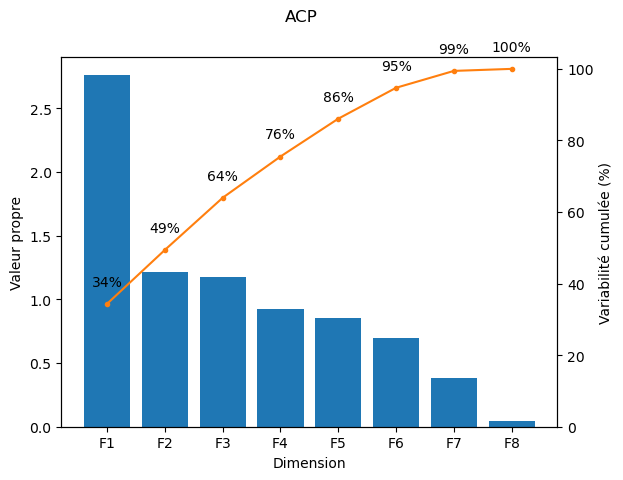

In [237]:
# Effectue la décomposition sur toutes les dimensions
pca = PCA()
pca = pca.fit(X_scaled)

# Initialse les variables
components = np.arange(1, (len(pca.explained_variance_)+1))
components = [f'F{x}' for x in components]

cum_variance_ratio = pca.explained_variance_ratio_.cumsum()

# Trace les graphiques
fig, ax1 = plt.subplots(figsize=(6.4, 4.8))
ax2 = ax1.twinx()

ax1.bar(components, pca.explained_variance_,)
ax2.plot(components, cum_variance_ratio, color='C1', marker='.')
for x, y in enumerate(cum_variance_ratio):
    ax2.text(x, (y+0.05) , f'{y:.0%}', ha='center')

# Définit la limite basse et le format de l'axe secondaire
ax2.set_ylim(bottom=0)
ax2.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: round(x*100))
)

ax1.set_xlabel('Dimension')
ax1.set_ylabel('Valeur propre')
ax2.set_ylabel('Variabilité cumulée (%)')

fig.suptitle('ACP')

plt.show()

del pca, components, cum_variance_ratio, fig, ax1, ax2, x, y

Les quatre premières valeurs propres correspondent à un pourcentage de variabilité de 76 %. La représentation sur **quatre dimensions** est donc de qualité suffisante, c'est ce nombre que nous choisissons de garder pour la suite.

In [240]:
# Effectue la décomposition
pca = PCA(n_components=4)
pca.fit(X_scaled)

X_pca = pca.transform(X_scaled)

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">Cercle des corrélations</h3>
</div>

On étudie ensuite les liaisons entre nos variables d'origine et les composantes principales en nous aidant du cercle des corrélations grâceà une une fonction qui va nous permettre de tracer ce cercle en fonction des composantes principales que l'on souhaite afficher.

In [244]:
def acp_corr_circle_plot(x_d, y_d, pca=pca, text_offset=0.04):
    '''
    Trace le cercle des corrérations d'une ACP.
    Paramètres :
    - x_d : la dimension de l'ACP a représenter sur l'axe x.
    - y_d : la dimension de l'ACP a représenter sur l'axe y.
    - pca : la décomposition effectuée.
    - text_offset : le décalage pour le positionnement des noms des
    indicateurs.
    '''

    # Initialise les variables
    eigenvectors = pca.components_.T
    cum_variance_ratio = (pca.explained_variance_ratio_[x_d]
                          + pca.explained_variance_ratio_[y_d])

    # Initialise le graphique
    fig, ax = plt.subplots(figsize=(6.4, 6.4))

    # Personnalise le graphique
    ax.set_aspect('equal')
    ax.grid(alpha=0.4)
    ax.set_axisbelow(True)
    ax.set_xlim(-1.02, 1.02)
    ax.set_ylim(-1.02, 1.02)
    
    for spine in ax.spines.values():
        spine.set_visible(False)

    # Trace le cercle et les axes en pointillés
    circle = plt.Circle((0, 0), 1, fill=False, linewidth=1, color='0.8')
    ax.add_patch(circle)
    ax.axhline(y=0, linestyle = '--', linewidth=0.9, color='k')
    ax.axvline(x=0, linestyle = '--', linewidth=0.9, color='k')

    # Représente les vecteurs
    for i in range(len(eigenvectors)):
        # Trace les flèches
        ax.annotate(
            text='',
            xy=(eigenvectors[i, x_d], eigenvectors[i, y_d]),
            xytext=(0, 0),
            arrowprops=dict(arrowstyle='->', linewidth=1, color='r')
        )

        # Paramètre la position texte (indicateurs)
        if eigenvectors[i, x_d] > 0:
            h_offset=text_offset
        elif eigenvectors[i, x_d] < 0:
            h_offset=-text_offset
        
        if eigenvectors[i, y_d] > 0:
            v_offset=text_offset
        elif eigenvectors[i, y_d] < 0:
            v_offset=-text_offset

        # Affiche les indicateurs
        ax.text(
            x=(eigenvectors[i, x_d]+h_offset), 
            y=(eigenvectors[i, y_d]+v_offset),
            s=indicateurs[i], fontsize='small'
        )

    # Ajoute les titre (axes et figure)
    ax.set_xlabel(f'F{x_d + 1} ({pca.explained_variance_ratio_[x_d]:.1%})')
    ax.set_ylabel(f'F{y_d + 1} ({pca.explained_variance_ratio_[y_d]:.1%})')

    ax.set_title(
        f'Cercle des corrélations\n'
        f'Dimensions F{x_d + 1} et F{y_d + 1} ({cum_variance_ratio:.1%})'
        )

    plt.tight_layout()

    plt.show()

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">On trace le cercle pour les deux premières dimensions</h3>
</div>

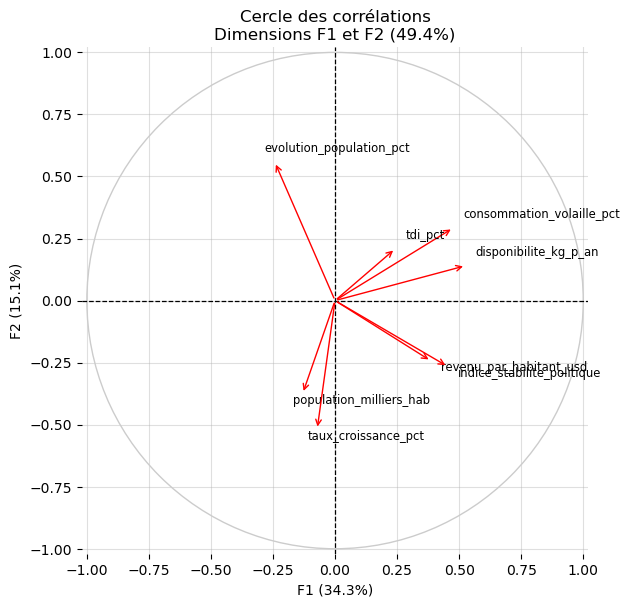

In [247]:
acp_corr_circle_plot(0, 1)

Les variables les plus corrélées à F1 sont :
* la disponibilité ;
* la part de consommation de volaille ;
* l'indice de stabilité politique ;
* le revenu par habitant.

Les variables les plus corrélées à F2 sont :
* le taux de croissance ;
* l'évolution démographique.


<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">On trace ensuite le cercle pour les deux autres composantes</h3>
</div>

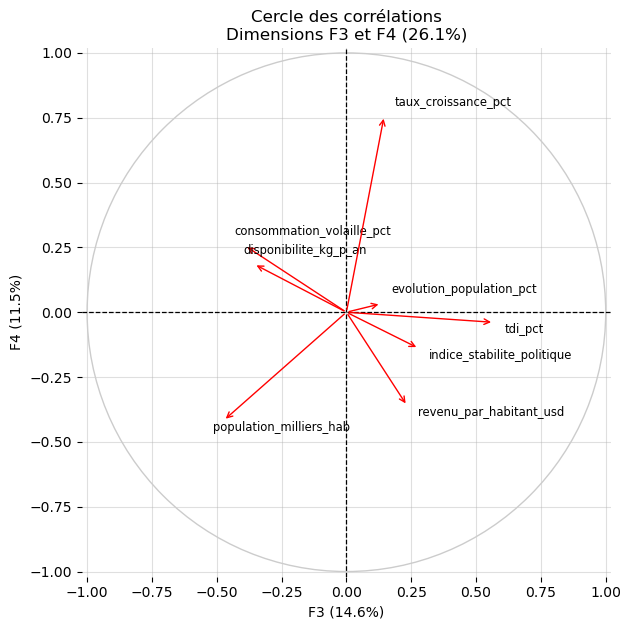

In [250]:
acp_corr_circle_plot(2, 3)

Les variables les plus corrélées à F3 sont :
* le taux de dépendance aux importations ;
* la taille de la population ;
* la part de consommation de volaille ;
* la disponibilité.

Les variables les plus corrélées à F4 sont :
* le taux de croissance ;
* la population ;
* le revenu par habitant.

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">On peut également afficher les corrélations sous forme de matrice</h3>
</div>

In [253]:
corr_indicateurs_pca = pd.DataFrame(
    np.transpose(pca.components_), index=indicateurs,
    columns=['F1', 'F2', 'F3', 'F4'])

(corr_indicateurs_pca
 .style.background_gradient(axis='rows', cmap='RdYlBu').format('{:.2f}'))

,F1,F2,F3,F4
population_milliers_hab,-0.13,-0.37,-0.47,-0.42
evolution_population_pct,-0.24,0.56,0.13,0.03
consommation_volaille_pct,0.48,0.29,-0.39,0.26
tdi_pct,0.24,0.21,0.57,-0.04
disponibilite_kg_p_an,0.53,0.14,-0.36,0.19
taux_croissance_pct,-0.07,-0.52,0.15,0.76
revenu_par_habitant_usd,0.39,-0.24,0.23,-0.36
indice_stabilite_politique,0.45,-0.27,0.28,-0.14


La matrice confirme les observations faites sur les cercles des corrélations.

In [256]:
del corr_indicateurs_pca

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">Représentation des individus sur les plans factoriels</h3>
</div>

Maintenant que nous avons créé de nouvelles variables, nous pouvons projeter les pays sur des plans composés par ces dernières. On crée une autre fonction qui va nous permettre de choisir les dimensions qui vont composer le plan que l'on souhaite représenter.

In [260]:
def acp_observations_plot(x_d, y_d, labels, pca=pca, text_offset=0.04):
    '''
    Trace le graphique des observations d'une ACP.
    Paramètres :
    - x_d : la dimension de l'ACP a représenter sur l'axe x.
    - y_d : la dimension de l'ACP a représenter sur l'axe y.
    - labels : la liste des noms des individus
    - pca : la décomposition effectuée.
    - text_offset : le décalage pour le positionnement des noms des
    indicateurs.
    '''

    # Initialise les variables
    cum_variance_ratio = (pca.explained_variance_ratio_[x_d]
                          + pca.explained_variance_ratio_[y_d])

    fig, ax = plt.subplots(figsize=(8, 8))

    # Personnalise le graphique
    ax.set_aspect('equal')
    ax.grid(alpha=0.4)
    ax.set_axisbelow(True)

    for spine in ax.spines.values():
        spine.set_visible(False)

    # Trace les lignes en pointillés pour x = 0  et y = 0
    ax.axhline(y=0, linestyle = '--', linewidth=0.9, color='k')
    ax.axvline(x=0, linestyle = '--', linewidth=0.9, color='k')

    # Affiche la position des individus
    ax.scatter(X_pca[:, x_d], X_pca[:, y_d], marker='.')

    # Ajoute les noms des individus
    for i in range(len(X_pca)):
        ax.text(
            x=(X_pca[i, x_d]+text_offset),
            y=(X_pca[i, y_d]+text_offset),
            s=labels[i], fontsize='x-small'
        )
    
    # Ajoute les titre (axes et figure)
    ax.set_xlabel(f'F{x_d + 1} ({pca.explained_variance_ratio_[x_d]:.1%})')
    ax.set_ylabel(f'F{y_d + 1} ({pca.explained_variance_ratio_[y_d]:.1%})')

    ax.set_title(f'Observations sur F{x_d + 1} et F{y_d + 1} '
                 f'({cum_variance_ratio:.1%})')

    plt.tight_layout()

    plt.show()

<div style="background-color: RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color:#fff; ">1.2 - Projections des individus</h3>
</div>

On va choisir de projecter nos pays sur un plan composé de F1 et de F3. En effet :
* plus un pays aura une valeur élevée sur F1, plus il aura une appétence pour le poulet tout en étant économiquement développé et fiable ;
* plus un pays aura faible valeur sur F3, plus aura besoin d'importer pour satisfaire ses besoins.

Cela devrait donc nous permettre d'identifier des pays intéressants pour notre objectif.

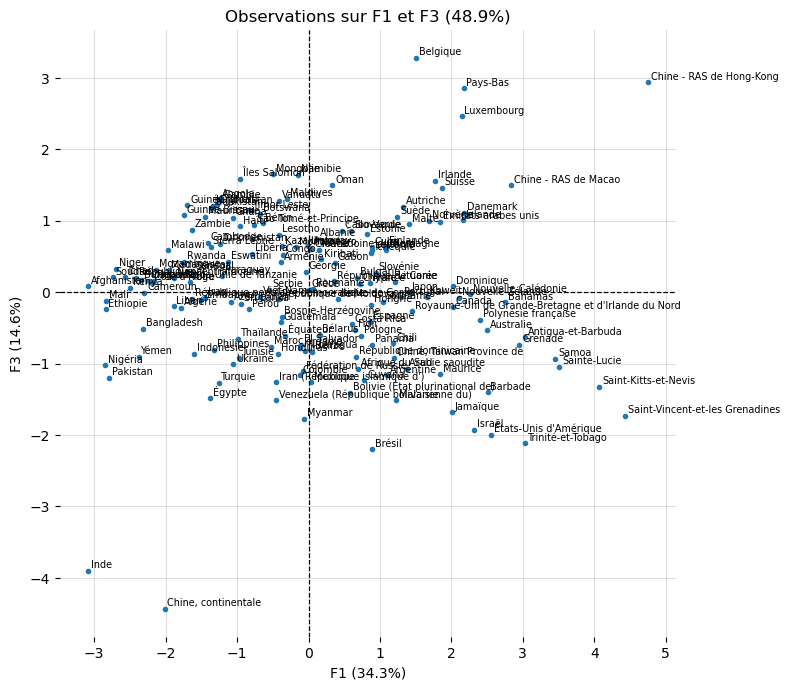

In [264]:
acp_observations_plot(0, 2, pays)

Sur la zone située à droite du plan, et avec une valeur sur F3 assez faible, on retouve des pays que nous pourrions cibler. Pour confirmer cela, on peut faire la même projection mais en affichant les *clusters* créés grâce à la CAH et aux k-means.

In [267]:
def acp_clusters_plot(x_d, y_d, clusters, pca=pca, X_pca=X_pca):
    '''
    Trace le graphique des observations d'une ACP avec leur cluster.
    Paramètres :
    - x_d : la dimension de l'ACP a représenter sur l'axe x.
    - y_d : la dimension de l'ACP a représenter sur l'axe y.
    - clusters : la série contenant les clusters.
    - pca : la décomposition effectuée.
    - X_pca : la matrice des individus avec les dimensions calculées
    '''

    # Initialise les variables
    cum_variance_ratio = (pca.explained_variance_ratio_[x_d]
                          + pca.explained_variance_ratio_[y_d])
    df = pd.DataFrame(X_pca)
    df['cluster'] = clusters
    n_clusters = len(df['cluster'].unique())
    markers = ['p', '+', '*', 'x']

    fig, ax = plt.subplots(figsize=(6.4, 6.4))

    # Personnalise le graphique
    ax.set_aspect('equal')
    ax.grid(alpha=0.4)
    ax.set_axisbelow(True)

    for spine in ax.spines.values():
        spine.set_visible(False)

    # Trace les lignes en pointillés pour x = 0  et y = 0
    ax.axhline(y=0, linestyle = '--', linewidth=0.9, color='k')
    ax.axvline(x=0, linestyle = '--', linewidth=0.9, color='k')

    # Affiche la position des individus
    for i in range(1, (n_clusters+1)):
        j = i % len(markers)
        ax.scatter(
            df.loc[df['cluster'] == i, x_d],
            df.loc[df['cluster'] == i, y_d],
            marker=markers[j], label=i
        )
   
    # Ajoute les titre (axes et figure)
    ax.set_xlabel(f'F{x_d + 1} ({pca.explained_variance_ratio_[x_d]:.1%})')
    ax.set_ylabel(f'F{y_d + 1} ({pca.explained_variance_ratio_[y_d]:.1%})')

    ax.set_title(f'Observations "{clusters.name}" sur F{x_d + 1} et F{y_d + 1}'
                 f' ({cum_variance_ratio:.1%})')

    fig.tight_layout()

    plt.legend(title='Cluster :')
 
    plt.show()

On projette nos groupes sur les dimensions F1 et F3 pour les deux méthodes de classification.

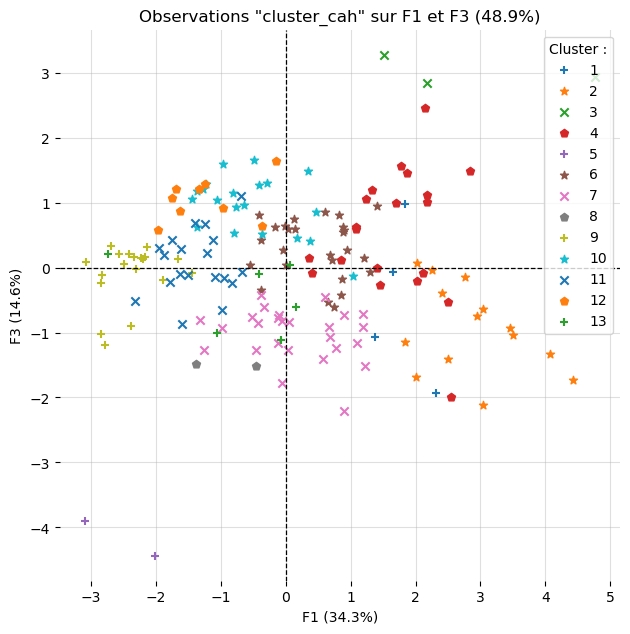

Clusters retenus avec la CAH : [3, 4]



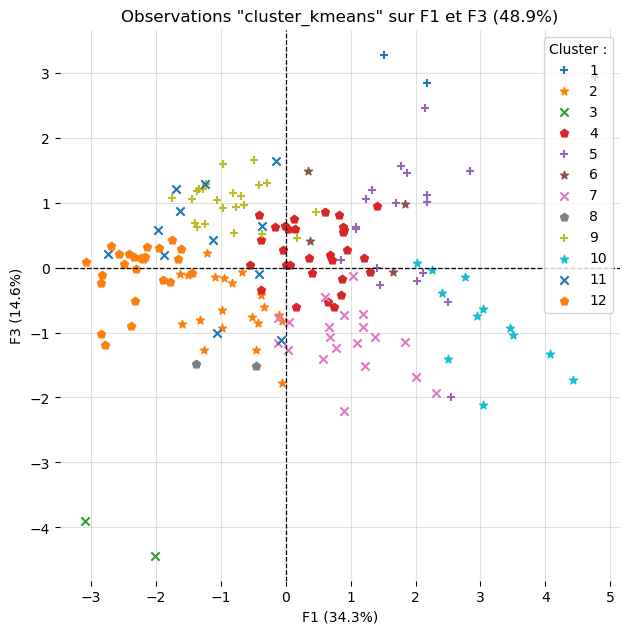

Clusters retenus avec les k-means : [5, 10]


In [270]:
acp_clusters_plot(0, 2, df_indicateurs['cluster_cah'])
print(f'Clusters retenus avec la CAH : {clusters_retenus_cah}\n')

acp_clusters_plot(0, 2, df_indicateurs['cluster_kmeans'])
print(f'Clusters retenus avec les k-means : {clusters_retenus_kmeans}')

Dans les deux cas, les *clusters* que nous avions retenus sont situés dans la zone du plan factoriel que nous avions identifié comme propice.

In [272]:
del  (X, indicateurs, pays, scaler, X_scaled, clusters_retenus_cah,
      clusters_retenus_kmeans, pca, X_pca)

<div style="background-color: RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color:#fff; ">Regroupements des pays en utilisant les données de l’ ACP ou les données brutes</h3>
</div>

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">Recommandation générale</h3>
</div>

Notre recommandation générale porte sur tous les pays retenus grâce aux deux méthodes de classification.

In [278]:
# Affiche le nombre de pays contenus dans chaque liste
print(f'Nombre de pays :')
print(f'- CAH : {len(pays_retenus_cah)}')
print(f'- k-means : {len(pays_retenus_kmeans)}')

Nombre de pays :
- CAH : 23
- k-means : 30


In [280]:
# Affiche les différences entre les liste
pays_differents = ((pays_retenus_cah-pays_retenus_kmeans)
                   .union(pays_retenus_kmeans-pays_retenus_cah))

print(f'Les pays qui diffèrent sont : {pays_differents}')

Les pays qui diffèrent sont : {'Polynésie française', 'Antigua-et-Barbuda', 'Saint-Vincent-et-les Grenadines', 'Pays-Bas', 'Dominique', 'Trinité-et-Tobago', 'Bahamas', 'Barbade', 'Samoa', 'Belgique', 'République de Corée', 'Grenade', 'Italie', 'Nouvelle-Calédonie', 'Saint-Kitts-et-Nevis', 'Chine - RAS de Hong-Kong', 'Sainte-Lucie'}


In [282]:
# Affiche tous les pays retenus
pays_retenus = pays_retenus_cah.union(pays_retenus_kmeans)
print(f'Liste des pays retenus :\n{pays_retenus}')

Liste des pays retenus :
{'Polynésie française', 'Finlande', 'Pays-Bas', 'Dominique', 'Bahamas', 'Barbade', 'Samoa', 'Norvège', 'Canada', 'Saint-Kitts-et-Nevis', 'Luxembourg', 'Suède', 'Allemagne', 'Chine - RAS de Hong-Kong', "États-Unis d'Amérique", 'Danemark', 'Suisse', 'Autriche', 'Nouvelle-Zélande', 'Antigua-et-Barbuda', 'Saint-Vincent-et-les Grenadines', 'Irlande', 'Trinité-et-Tobago', 'Australie', 'Sainte-Lucie', 'Belgique', 'Chine - RAS de Macao', 'République de Corée', "Royaume-Uni de Grande-Bretagne et d'Irlande du Nord", 'Grenade', 'Italie', 'Nouvelle-Calédonie', 'Japon', 'Islande', 'France'}


In [284]:
del pays_retenus_cah, pays_retenus_kmeans, pays_differents

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">Recommandation ciblée</h3>
</div>

Pour rappel, notre entreprise souhaite démarrer son activité à l'internationale. Pour affiner notre recommandation, on retire dans un premier temps les pays qui sont loin de la France (logistique) et/ou les pays ayant une population trop importante (capacité à répondre à la demande).

In [288]:
# Crée la liste des pays à supprimer
pays_a_supprimer = {'Australie', 'Canada', 'Chine - RAS de Hong-Kong',
                    'Chine - RAS de Macao', 'France', 'Japon',
                    'Nouvelle-Zélande', 'République de Corée',
                    "États-Unis d'Amérique"}

# Supprime les pays non retenus
pays_retenus = pays_retenus - pays_a_supprimer

del pays_a_supprimer

Puis on affiche leurs caractéristiques dans un *DataFrame*.

In [291]:
# Crée un DataFrame avec les pays retenus
df_pays_retenus = (
    df_indicateurs.loc[df_indicateurs['pays'].isin(pays_retenus)]
    .drop(columns={'cluster_cah', 'cluster_kmeans'})
    .reset_index(drop=True)
)

# Affiche les indicateurs pour les pays retenus
df_pays_retenus.nlargest(
    15, ['population_milliers_hab', 'tdi_pct', 'consommation_volaille_pct'])

,pays,population_milliers_hab,evolution_population_pct,consommation_volaille_pct,tdi_pct,disponibilite_kg_p_an,taux_croissance_pct,revenu_par_habitant_usd,indice_stabilite_politique
0,Allemagne,82658.409,0.12,2.06,49.24,19.47,6.441277,45734.557505,0.59
18,Royaume-Uni de Grande-Bretagne et d'Irlande du...,66727.461,0.73,3.53,34.87,31.94,-0.602323,40180.334509,0.39
12,Italie,60673.701,0.37,2.01,7.89,18.88,4.584649,32876.705685,0.31
16,Pays-Bas,17021.347,0.38,2.15,209.66,20.33,6.424971,47903.524246,0.92
5,Belgique,11419.748,0.62,1.24,233.10,12.65,5.680656,44567.104136,0.43
23,Suède,9904.896,0.65,1.78,38.53,16.60,4.918811,54722.389207,0.98
2,Autriche,8819.901,0.54,1.95,61.11,18.20,5.483879,46984.806575,1.05
24,Suisse,8455.804,0.99,1.69,36.96,15.72,1.276287,81118.449926,1.26
6,Danemark,5732.274,0.41,3.01,79.64,28.98,6.069680,59155.352620,0.87
8,Finlande,5511.371,0.35,1.70,12.03,18.76,6.250864,46435.935525,1.08


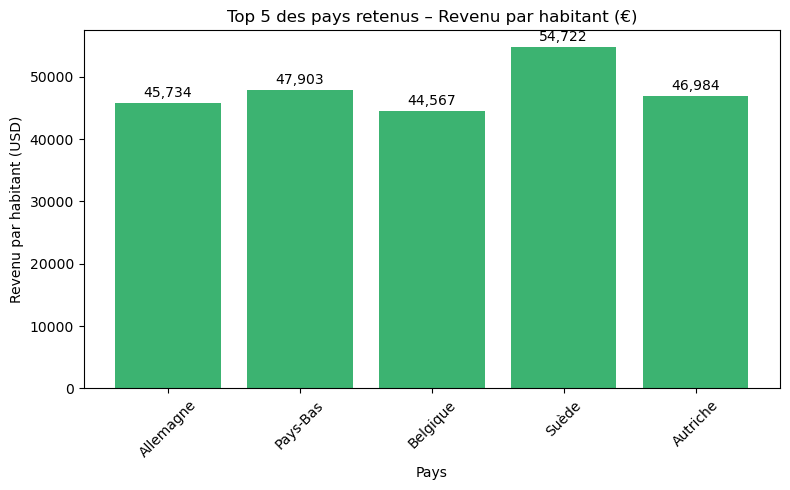

In [293]:
# Données du top 5 final (hors UK et Italie)
top5_data = {
    'Pays': ['Allemagne', 'Pays-Bas', 'Belgique', 'Suède', 'Autriche'],
    'revenu_par_habitant': [
        45734.56,  # Allemagne
        47903.52,  # Pays-Bas
        44567.10,  # Belgique
        54722.39,  # Suède
        46984.81   # Autriche
    ]
}

df_top5 = pd.DataFrame(top5_data)

# Création du graphique
plt.figure(figsize=(8, 5))
bars = plt.bar(df_top5['Pays'], df_top5['revenu_par_habitant'], color='mediumseagreen')
plt.title("Top 5 des pays retenus – Revenu par habitant (€)")
plt.xlabel("Pays")
plt.ylabel("Revenu par habitant (USD)")
plt.xticks(rotation=45)
plt.tight_layout()

# Ajouter les valeurs au-dessus des barres
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 500, f'{int(yval):,}', ha='center', va='bottom')

plt.show()

<div style="border: 1px solid RGB(51,165,182);" >
<h3 style="margin: auto; padding: 20px; color: RGB(51,165,182); ">TOP 5 PAYS</h3>
</div>

Notre top 5 final porte sur les pays suivants :
1. Allemagne
1. Pays-Bas
1. Belgique
1. Suède
1. Autriche

Le Royaume-Uni a été retiré car suite au Brexit, les échanges commerciaux sont plus compliqués. L'Italie a également été retirée car elle a l'un des plus faible taux de dépendance aux importations et le revenu par habitant le plus faible.